In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report

import cv2
import numpy as np

import itertools
import os
import shutil
import random
import glob
import time

In [2]:
TRAIN_DIR = '../input/road-data/train'
TEST_DIR = '../input/road-data/test'
VALID_DIR = '../input/road-data/valid'

In [3]:
labels = ["good", "medium", "bad", "unpaved"]

train_batches = ImageDataGenerator().flow_from_directory(directory=TRAIN_DIR, target_size=(124,224), classes=labels)
test_batches = ImageDataGenerator().flow_from_directory(directory=TEST_DIR, target_size=(124,224), classes=labels, shuffle=False)
valid_batches = ImageDataGenerator().flow_from_directory(directory=VALID_DIR, target_size=(124,224), classes=labels)

train_batches_vgg = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=TRAIN_DIR, target_size=(124,224), classes=labels)
test_batches_vgg = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=TEST_DIR, target_size=(124,224), classes=labels, shuffle=False)
valid_batches_vgg = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=VALID_DIR, target_size=(124,224), classes=labels)

train_batches_mnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory=TRAIN_DIR, target_size=(124,224), classes=labels)
test_batches_mnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory=TEST_DIR, target_size=(124,224), classes=labels, shuffle=False)
valid_batches_mnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory=VALID_DIR, target_size=(124,224), classes=labels)

Found 12178 images belonging to 4 classes.
Found 3478 images belonging to 4 classes.
Found 1738 images belonging to 4 classes.
Found 12178 images belonging to 4 classes.
Found 3478 images belonging to 4 classes.
Found 1738 images belonging to 4 classes.
Found 12178 images belonging to 4 classes.
Found 3478 images belonging to 4 classes.
Found 1738 images belonging to 4 classes.


In [4]:
custom = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),padding ='same',strides=(2,2),activation='relu',input_shape=(124,224,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(5,5),padding ='same',strides=(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(5,5),padding ='same',strides=(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(5,5),padding ='same',strides=(2,2),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])
custom.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

2022-06-20 15:18:20.452179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:18:20.543368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:18:20.544157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 15:18:20.545992: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
history_custom = custom.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

2022-06-20 15:18:23.319678: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-20 15:18:24.814019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


381/381 [==============================] - 64s 150ms/step - loss: 1.4246 - accuracy: 0.3023 - val_loss: 1.0100 - val_accuracy: 0.4816
Epoch 2/10
381/381 [==============================] - 25s 66ms/step - loss: 1.2671 - accuracy: 0.3806 - val_loss: 1.0830 - val_accuracy: 0.4712
Epoch 3/10
381/381 [==============================] - 25s 66ms/step - loss: 1.0515 - accuracy: 0.4626 - val_loss: 0.9622 - val_accuracy: 0.5115
Epoch 4/10
381/381 [==============================] - 26s 68ms/step - loss: 0.9797 - accuracy: 0.5269 - val_loss: 0.8833 - val_accuracy: 0.5570
Epoch 5/10
381/381 [==============================] - 25s 65ms/step - loss: 0.9389 - accuracy: 0.5658 - val_loss: 0.8970 - val_accuracy: 0.5564
Epoch 6/10
381/381 [==============================] - 26s 68ms/step - loss: 0.8333 - accuracy: 0.6547 - val_loss: 0.5637 - val_accuracy: 0.7825
Epoch 7/10
381/381 [==============================] - 25s 66ms/step - loss: 0.6431 - accuracy: 0.7631 - val_loss: 0.5870 - val_accuracy: 0.7624
Ep

In [6]:
vbase = VGG16(weights='imagenet',include_top=False,input_shape=(124, 224, 3))
vbase.trainable = False

vgg_fe = tf.keras.Sequential()
vgg_fe.add(vbase)
vgg_fe.add(tf.keras.layers.Flatten())
vgg_fe.add(tf.keras.layers.Dense(256, activation='relu'))
vgg_fe.add(tf.keras.layers.Dense(4, activation='softmax'))

vgg_fe.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


In [7]:
history_vgg_fe = vgg_fe.fit(
    x=train_batches_vgg,
    steps_per_epoch=len(train_batches_vgg),
    validation_data=valid_batches_vgg,
    validation_steps=len(valid_batches_vgg),
    epochs=10,
    verbose=1    
)

Epoch 1/10
381/381 [==============================] - 36s 88ms/step - loss: 0.2634 - accuracy: 0.9494 - val_loss: 0.0597 - val_accuracy: 0.9793
Epoch 2/10
381/381 [==============================] - 33s 88ms/step - loss: 0.0328 - accuracy: 0.9886 - val_loss: 0.1127 - val_accuracy: 0.9718
Epoch 3/10
381/381 [==============================] - 33s 87ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0634 - val_accuracy: 0.9827
Epoch 4/10
381/381 [==============================] - 34s 88ms/step - loss: 0.0308 - accuracy: 0.9923 - val_loss: 0.0974 - val_accuracy: 0.9799
Epoch 5/10
381/381 [==============================] - 32s 85ms/step - loss: 0.0655 - accuracy: 0.9870 - val_loss: 0.1344 - val_accuracy: 0.9787
Epoch 6/10
381/381 [==============================] - 32s 84ms/step - loss: 0.0316 - accuracy: 0.9936 - val_loss: 0.1527 - val_accuracy: 0.9758
Epoch 7/10
381/381 [==============================] - 33s 86ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0950 - val_accuracy:

In [8]:
mbase = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(124, 224, 3),include_top=False, weights='imagenet')
mbase.trainable = False

mnet_fe = tf.keras.Sequential()
mnet_fe.add(mbase)
mnet_fe.add(tf.keras.layers.Flatten())
mnet_fe.add(tf.keras.layers.Dense(256, activation='relu'))
mnet_fe.add(tf.keras.layers.Dense(4, activation='softmax'))

mnet_fe.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
history_mnet_fe = mnet_fe.fit(
    x=train_batches_mnet,
    steps_per_epoch=len(train_batches_mnet),
    validation_data=valid_batches_mnet,
    validation_steps=len(valid_batches_mnet),
    epochs=10,
    verbose=1    
)

Epoch 1/10
381/381 [==============================] - 32s 77ms/step - loss: 0.5573 - accuracy: 0.9405 - val_loss: 0.1682 - val_accuracy: 0.9528
Epoch 2/10
381/381 [==============================] - 30s 79ms/step - loss: 0.0517 - accuracy: 0.9832 - val_loss: 0.0904 - val_accuracy: 0.9753
Epoch 3/10
381/381 [==============================] - 30s 79ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.0904 - val_accuracy: 0.9845
Epoch 4/10
381/381 [==============================] - 30s 80ms/step - loss: 0.0382 - accuracy: 0.9890 - val_loss: 0.1349 - val_accuracy: 0.9753
Epoch 5/10
381/381 [==============================] - 30s 80ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.1129 - val_accuracy: 0.9781
Epoch 6/10
381/381 [==============================] - 29s 76ms/step - loss: 0.0212 - accuracy: 0.9947 - val_loss: 0.1035 - val_accuracy: 0.9827
Epoch 7/10
381/381 [==============================] - 27s 71ms/step - loss: 0.0320 - accuracy: 0.9918 - val_loss: 0.2115 - val_accuracy:

In [10]:
t = time.time()
custom.evaluate(test_batches)
print(time.time()-t)

t = time.time()
vgg_fe.evaluate(test_batches_vgg)
print(time.time()-t)

t = time.time()
mnet_fe.evaluate(test_batches_mnet)
print(time.time()-t)

109/109 [==============================] - 15s 142ms/step - loss: 0.3887 - accuracy: 0.8577
15.69215703010559
109/109 [==============================] - 9s 86ms/step - loss: 0.0808 - accuracy: 0.9885
9.50867772102356
109/109 [==============================] - 7s 66ms/step - loss: 0.0714 - accuracy: 0.9859
7.360980749130249


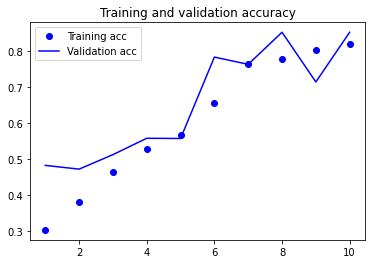

In [11]:
acc = history_custom.history['accuracy']
val_acc = history_custom.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

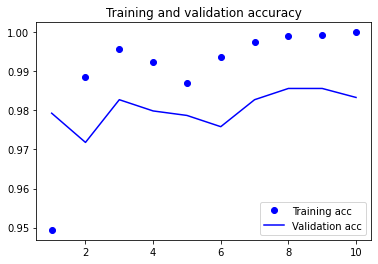

In [12]:
acc = history_vgg_fe.history['accuracy']
val_acc = history_vgg_fe.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

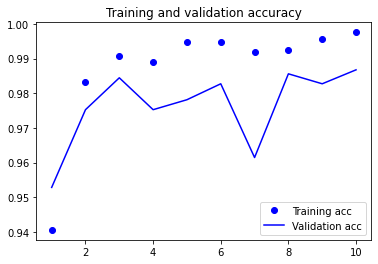

In [13]:
acc = history_mnet_fe.history['accuracy']
val_acc = history_mnet_fe.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [14]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[644 148   3  19]
 [107 838  10  17]
 [  7 151 611  10]
 [ 13   5   5 890]]


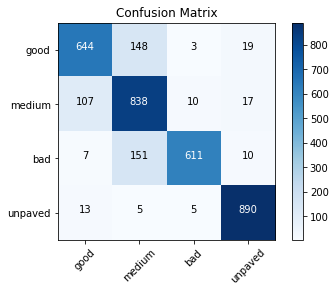

In [15]:
predictions = custom.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ["good", "medium", "bad", "unpaved"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[803  11   0   0]
 [  7 958   6   1]
 [  0   7 769   3]
 [  1   0   4 908]]


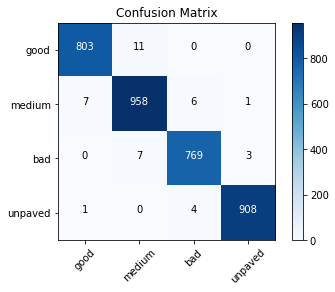

In [16]:
predictions = vgg_fe.predict(x=test_batches_vgg, steps=len(test_batches_vgg), verbose=0)
cm = confusion_matrix(y_true=test_batches_vgg.classes, y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ["good", "medium", "bad", "unpaved"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[799  14   0   1]
 [ 12 952   8   0]
 [  0   1 769   9]
 [  0   0   4 909]]


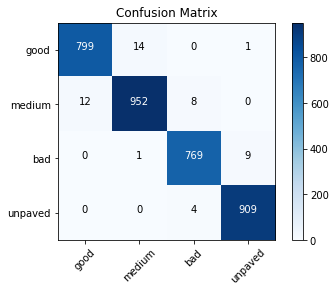

In [17]:
predictions = mnet_fe.predict(x=test_batches_mnet, steps=len(test_batches_mnet), verbose=0)
cm = confusion_matrix(y_true=test_batches_mnet.classes, y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ["good", "medium", "bad", "unpaved"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [18]:
y_pred = custom.predict(test_batches, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_batches.classes, y_pred_bool))

109/109 [==============================] - 6s 54ms/step
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       814
           1       0.73      0.86      0.79       972
           2       0.97      0.78      0.87       779
           3       0.95      0.97      0.96       913

    accuracy                           0.86      3478
   macro avg       0.87      0.85      0.86      3478
weighted avg       0.87      0.86      0.86      3478



In [19]:
y_pred = vgg_fe.predict(test_batches_vgg, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_batches_vgg.classes, y_pred_bool))

109/109 [==============================] - 7s 63ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       814
           1       0.98      0.99      0.98       972
           2       0.99      0.99      0.99       779
           3       1.00      0.99      1.00       913

    accuracy                           0.99      3478
   macro avg       0.99      0.99      0.99      3478
weighted avg       0.99      0.99      0.99      3478



In [20]:
y_pred = mnet_fe.predict(test_batches_mnet, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_batches_mnet.classes, y_pred_bool))

109/109 [==============================] - 6s 58ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       814
           1       0.98      0.98      0.98       972
           2       0.98      0.99      0.99       779
           3       0.99      1.00      0.99       913

    accuracy                           0.99      3478
   macro avg       0.99      0.99      0.99      3478
weighted avg       0.99      0.99      0.99      3478



In [21]:
custom.save('./custom1.h5')
vgg_fe.save('./vgg.h5')
mnet_fe.save('./mnet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
